In [1]:
import sys
import numpy as np

import matplotlib.pyplot as plt
from  torch.utils.data import Dataset, DataLoader,random_split
from torchvision.transforms import ToTensor, CenterCrop
from torchvision import transforms 
from sklearn.preprocessing import StandardScaler
from torch.distributions import Normal

import math
import torch
import torch.distributions as td
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'

import random 
import torchvision
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import networkx as nx
import yaml

from pathlib import Path
macaw_path = '/home/erik.ohara/macaw'
sys.path.append(macaw_path +'/')
from macaw.flows import Flow, NormalizingFlowModel
from utils.datasets import UKBBT1Dataset, CustomDataset
from utils.customTransforms import ToFloatUKBB
from utils.visualize import grid_show, img_grid
from compression.autoencoder.AE import AE
from utils.helpers import dict2namespace
from macaw import MACAW

import pickle
from tqdm.notebook import tqdm
import pandas as pd

In [3]:
slice_initial = 16
slice_final = 166

n_slices = slice_final - slice_initial
nevecs = 50
ncauses = 2
ncomps = 1500
nbasecomps = 25
ukbb_path = '/home/erik.ohara/UKBB'
evec_path = '/work/forkert_lab/erik/PCA/slices-y'
model_path = '/work/forkert_lab/erik/MACAW/models/2_5DY'
reshaped_path = '/work/forkert_lab/erik/MACAW/reshaped/slices-x'
output_image = '/work/forkert_lab/erik/MACAW/cf_images/2_5Y'
original_images = "/work/forkert_lab/erik/T1_warped"
cf_age_definition = 70

In [4]:
all_data = []
all_data_dim = []
for y_slice in tqdm(range(slice_initial,slice_final)):
    data = np.load(reshaped_path + '/reshaped_test_slice_{}.npy'.format(y_slice))
    all_data.append(data)
    all_data_dim.append(data.shape[1])

  0%|          | 0/150 [00:00<?, ?it/s]

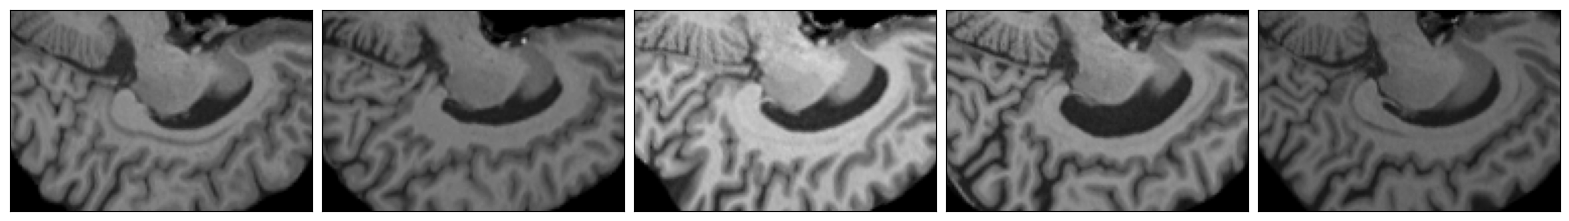

In [6]:
import utils.visualize as vis

y_slice = 80
plt.rcParams["figure.figsize"] = 20,5

fig = vis.img_grid([d.reshape(100,150) for d in all_data[y_slice-slice_initial][:5,:]], clim=(0,1), cols=5)

In [ ]:
all_evecs = []
for y_slice in range(slice_initial,slice_final):
    with open(evec_path + '/evecs_slice_{}.pkl'.format(y_slice),'rb') as f:  
        evecs = pickle.load(f)
        all_evecs.append(evecs)

In [ ]:
def encode(data, evecs):
    return np.matmul(data,evecs)

def decode(data,evecs):
    return np.matmul(data,evecs.T)

In [ ]:
data_path = ukbb_path + '/ukbb_img.csv'

df = pd.read_csv(data_path,low_memory=False)

In [ ]:
# getting the only the test set
df_test = pd.DataFrame(columns=df.columns)
# test folder
for each_file in os.listdir(original_images + '/test'):
    if '.nii' in each_file:
        file_id = each_file.split('.nii')[0]
        df_test = pd.concat([df[df['eid'] == int(file_id)],df_test.loc[:]]).reset_index(drop=True)
df_test.sort_values(by=['eid'], inplace=True)

df = df_test
print(f"The size of the dataframe (just test set) is {df.shape}")

In [ ]:
all_eid = df[['eid']].to_numpy()
#causes = df[['Age','Sex']].to_numpy()
min_age = df['Age'].min()
print(f"Age min: {min_age}")
sex = df['Sex'] 
age = df['Age'] - min_age

In [ ]:
with open(macaw_path + '/config/ukbb.yaml', 'r') as f:
    config_raw = yaml.load(f, Loader=yaml.FullLoader)

In [ ]:
config = dict2namespace(config_raw)
config.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
number_images = 5

    
cf_vals = {1:cf_age_definition - min_age}
nsamples = number_images

rands = np.random.randint(0,all_data[0].shape[0],nsamples)    
#c_obs = causes[rands,:]
sex_obs = sex[rands]
age_obs = age[rands]
random_eids = all_eid[rands,0]

all_d_obs = []

In [ ]:
for y_slice in range(slice_initial,slice_final):
    order_slice = y_slice - slice_initial
    all_d_obs.append(all_data[order_slice][rands,:])

In [ ]:
all_s = []
all_c_cf = [np.zeros((nsamples,ncomps)) for _ in range(slice_initial,slice_final)]
for y_slice in tqdm(range(slice_initial,slice_final)):
    order_slice = y_slice - slice_initial
    #d_encodes = []
    s=0
    for ev in range(0,ncomps-nbasecomps,nevecs-nbasecomps):
        encoded_obs =  encode(all_d_obs[order_slice],all_evecs[order_slice][:,ev:ev+nevecs])   
        try:
            '''
            macaw = MACAW.MACAW(config)
            print("Iniciando modelo")
            macaw.model = NormalizingFlowModel([],[Flow(nevecs + 4,[(1,2)],config.device)]).to(config.device)
            print("Iniciando carregamento")
            macaw.model.load_state_dict(torch.load(model_path + f'/slice_{y_slice}/{nevecs}/macaw_ukbb_PCA_{ev}_cpu.pt',
                                                    map_location=config.device), strict=False)
            '''
            macaw = torch.load(model_path + f'/slice_{y_slice}/macaw_ukbb_PCA_{ev}.pt') 
            X_obs = np.hstack([sex_obs[:,np.newaxis], age_obs[:,np.newaxis], encoded_obs]) 

            cc = macaw.counterfactual(X_obs,cf_vals)
        except FileNotFoundError as e:
            cc[:,ncauses:] = X_obs[:,ncauses:].copy()
        all_c_cf[order_slice][:,ev:ev+nevecs] = cc[:,ncauses:]
        s+=1
    all_s.append(s)

In [ ]:
age_obs_sub = age_obs + min_age
sex_obs_sub = ['Male' if round(s) else 'Female' for s in age_obs]
titles = [f'Age:{a}, Sex:{s}' for a,s in zip(age_obs_sub,sex_obs_sub)]


sex_cf = ['Male' if round(s) else 'Female' for s in cc[:,0]]
age_cf = cc[:,1] + min_age
titles_cf = [f'Age:{np.round(a)}, Sex:{s}' for a,s in zip(age_cf,sex_cf)]

In [ ]:
all_decoded_cf = []
for y_slice in tqdm(range(slice_initial,slice_final)):
    order_slice = y_slice - slice_initial
    #encoded_cf = np.hstack(all_d_encodes[order_slice])
    decoded_cf = decode(all_c_cf[order_slice],all_evecs[order_slice][:,:ncomps])
    all_decoded_cf.append(decoded_cf)

In [ ]:
for individual in range(nsamples):
    numpy_image = np.array([])
    for y_slice in range(slice_initial,slice_final):
        order_slice = y_slice - slice_initial
        if order_slice == 0:
            numpy_image = all_decoded_cf[order_slice][individual].reshape(100,150)
        else:
            numpy_image = np.dstack((numpy_image,all_decoded_cf[order_slice][individual].reshape(100,150)))
    numpy_image = np.swapaxes(numpy_image,0,1)
    numpy_image = np.swapaxes(numpy_image,0,2)
    # Getting the orifinal affine and header
    image_path = original_images + '/test/' + str(random_eids[individual]) + '.nii.gz'

In [ ]:
sample_imgs = data[:5,:]

In [ ]:
len(all_decoded_cf[75])

In [ ]:
plt.rcParams["figure.figsize"] = 20,5

fig = vis.img_grid([d.reshape(100,150) for d in all_decoded_cf[150-34]], clim=(0,1), cols=5)